In [1]:
import os
import sys
import json
from pathlib import Path
sys.path.append(os.path.abspath('..'))

# ----------- local imports ----------- 
from utils import show_images, build_wandb_run

In [2]:
model_id = "SG161222/Realistic_Vision_V6.0_B1_noVAE"
vae_link = "https://huggingface.co/stabilityai/sd-vae-ft-mse-original/vae-ft-mse-840000-ema-pruned.ckpt"

In [9]:
import torch
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import UNet2DConditionModel, AutoencoderKL, PNDMScheduler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = torch.Generator(device=device).manual_seed(42)
dtype = torch.bfloat16

In [4]:
def _get_prompt_embeddings():
    """ get inital prompt embeddings to help model """
    # text encoder components
    tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=dtype)
    text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=dtype)#.to(device)

    prompt = "An ultra high-resolution, photorealistic image in 8K, A highly detailed photo, showcasing vivid colors and rich contrasts, portrait photo, perfect anatomy, 4k, high quality"
    negative_prompt = "nudity (deformed iris, deformed pupils, semi-realistic, cgi, 3d, render, sketch, cartoon, drawing, anime), text, cropped, out of frame, worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, mutilated, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, blurry, dehydrated, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers, long neck"
        
    # Tokenize positive and negative prompts
    positive_token_ids = tokenizer(prompt, padding="max_length", truncation=True, return_tensors="pt")['input_ids']#.to(device)
    negative_token_ids = tokenizer(negative_prompt, padding="max_length", truncation=True, return_tensors="pt")['input_ids']#.to(device)

    # Generate embeddings
    with torch.no_grad():
        positive_embeddings = text_encoder(positive_token_ids).last_hidden_state.type(dtype).to(device)
        negative_embeddings = text_encoder(negative_token_ids).last_hidden_state.type(dtype).to(device)

        combined_embeddings = torch.cat([negative_embeddings, positive_embeddings], dim=0)#.type(dtype)
    
    return positive_embeddings, negative_embeddings, combined_embeddings


In [10]:
scheduler = PNDMScheduler.from_pretrained(model_id, subfolder="scheduler")

In [5]:
vae = AutoencoderKL.from_single_file(vae_link, torch_dtype=dtype).to(device)

unet = UNet2DConditionModel.from_pretrained(model_id, 
                                            subfolder="unet",
                                            torch_dtype=dtype
                                        ).to(device)

An error occurred while trying to fetch SG161222/Realistic_Vision_V6.0_B1_noVAE: SG161222/Realistic_Vision_V6.0_B1_noVAE does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [ ]:
nsamples = 1
image_size = (256, 352)
latent_size = (256 // 8, 352 // 8)

In [12]:
positive_embeddings, negative_embeddings, combined_embeddings =  _get_prompt_embeddings()

In [ ]:
scheduler.set_timesteps(50)

latents = torch.randn((nsamples, unet.config.in_channels, latent_size[0], latent_size[1] ), dtype=dtype, device = device, generator=generator)

guidance_scale = 2.0
embeddings = torch.cat([
                        positive_embeddings.repeat(nsamples, 1, 1), 
                        negative_embeddings.repeat(nsamples, 1, 1)
])

for i, t in enumerate(tqdm(scheduler.timesteps)):
    latents_in = torch.cat([latents] * 2)
    with torch.no_grad():
        noise_pred = unet(latents_in, t, encoder_hidden_states=embeddings).sample
        
    noise_pos, noise_neg = noise_pred.chunk(2)
    noise_pred = noise_neg + guidance_scale * (noise_pos - noise_neg)
    latents = scheduler.step(noise_pred, t, latents).prev_sample

  0%|          | 0/51 [00:00<?, ?it/s]

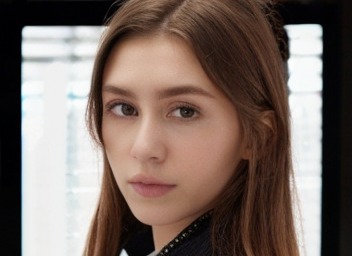

In [22]:
latents /= 0.18215
with torch.no_grad():
    image = vae.decode(latents).sample
    
show_images(image.detach().type(torch.float32))